Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

In [1]:
import retinoto_py as fovea
args = fovea.Params(do_mask=True, num_epochs=17)
# args = fovea.Params(do_mask=True, subset_factor=5, do_full_training=False, num_epochs=15, lr=1e-4) HACK to do here: first phase to retrain the classifier, then adjust weights
args

Params(image_size=224, do_mask=True, do_fovea=False, rs_min=0.0, rs_max=-7.5, padding_mode='zeros', seed=2025, batch_size=80, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=17, subset_factor=1, lr=2e-07, delta1=0.2, delta2=0.007, weight_decay=0.003, label_smoothing=0.05, do_full_training=False, shuffle=True, verbose=False)

# transfer learning of each network on the  masked dataset

In [2]:
%ls -ltr cached_data/20*

-rw-r--r--  1 laurentperrinet  staff  354499245  6 déc.  19:46 cached_data/20_model_name=convnext_base_dataset=bbox.pth
-rw-r--r--  1 laurentperrinet  staff       2160  6 déc.  19:55 cached_data/20_model_name=convnext_base_dataset=bbox.json


In [3]:
# %rm "cached_data/20_mls -ltrodel_name=convnext_base_dataset=bbox.lock"   # FORCING RECOMPUTE
# %rm "cached_data/20_*.lock"   # FORCING RECOMPUTE
%rm "cached_data/20_model_name=convnext_base_dataset=bbox.lock"   # FORCING RECOMPUTE
# %rm cached_data/20*

rm: cached_data/20_model_name=convnext_base_dataset=bbox.lock: No such file or directory


In [4]:
model_name = args.model_name
for dataset in ['bbox']: # fovea.params.all_datasets:
    name = f'20_model_name={model_name}_dataset={dataset}'
    model_filename, json_filename = fovea.do_learning(args, dataset, name)
    print(50*'.')

Load JSON from pre-trained resnet cached_data/20_model_name=convnext_base_dataset=bbox.json
cached_data/20_model_name=convnext_base_dataset=bbox.pth: latest accuracy = 0.747
Training model convnext_base, file= cached_data/20_model_name=convnext_base_dataset=bbox.pth - image_size=224


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch=13/17:   0%|          | 0/7691 [00:03<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/1005 [00:03<?, ?it/s]

Epoch=14/17:   0%|          | 0/7691 [00:03<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/1005 [00:02<?, ?it/s]

Epoch=15/17:   0%|          | 0/7691 [00:03<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/1005 [00:02<?, ?it/s]

Epoch=16/17:   0%|          | 0/7691 [00:03<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/1005 [00:02<?, ?it/s]

Epoch=17/17:   0%|          | 0/7691 [00:03<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/1005 [00:02<?, ?it/s]

Training of ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          

## Model comparison

In [5]:
model_name = args.model_name
for dataset in ['bbox']: # fovea.params.all_datasets:
    results = fovea.pd.read_json(args.data_cache / f'20_model_name={model_name}_dataset={dataset}.json')
    print(model_name, dataset, results.tail(1)['acc_val'])

convnext_base bbox 16    0.742624
Name: acc_val, dtype: float64


In [10]:
results

,epoch,i_image,total_image,loss_train,acc_train,acc_val,time
0,0,615280,615280,0.367325,0.183375,0.002127,7061.567748
1,1,615280,1230560,0.150311,0.001325,0.002251,14210.541431
2,2,615280,1845840,0.072473,0.006046,0.015025,21278.239955
3,3,615280,2461120,0.034280,0.057676,0.111940,30808.037847
4,4,50000,50000,0.022540,0.128580,0.112500,332.306991
5,5,50000,100000,0.021312,0.131040,0.112900,565.880219
6,6,50000,150000,0.020166,0.132460,0.111900,790.243177
7,7,50000,200000,0.019102,0.131820,0.112100,1014.586353
8,8,50000,250000,0.018111,0.130700,0.111300,1239.127110
9,9,50000,300000,0.017187,0.131580,0.112600,1463.918579


In [7]:
results_13 = fovea.pd.read_json(args.data_cache / '13_model_comparison.json')
results_13

,model_name,do_mask,dataset,accuracy,wall_clock_time,total_parameters,trainable_parameters,total_layers
0,resnet18,True,full,0.515400,0.003884,11689512,11689512,68
1,resnet50,True,full,0.788860,0.005536,25557032,25557032,151
2,resnet101,True,full,0.801120,0.007081,44549160,44549160,287
3,resnet18,True,bbox,0.430846,0.004722,11689512,11689512,68
4,resnet50,True,bbox,0.721915,0.006415,25557032,25557032,151
5,resnet101,True,bbox,0.751393,0.007409,44549160,44549160,287
6,resnet18,False,full,0.691620,0.004008,11689512,11689512,68
7,resnet50,False,full,0.807600,0.005385,25557032,25557032,151
8,resnet101,False,full,0.817300,0.007105,44549160,44549160,287
9,resnet18,False,bbox,0.627786,0.004341,11689512,11689512,68


## Plot learning evolution

Load JSON from pre-trained resnet cached_data/20_model_name=convnext_base_dataset=bbox.json
cached_data/20_model_name=convnext_base_dataset=bbox.pth: latest accuracy = 0.743


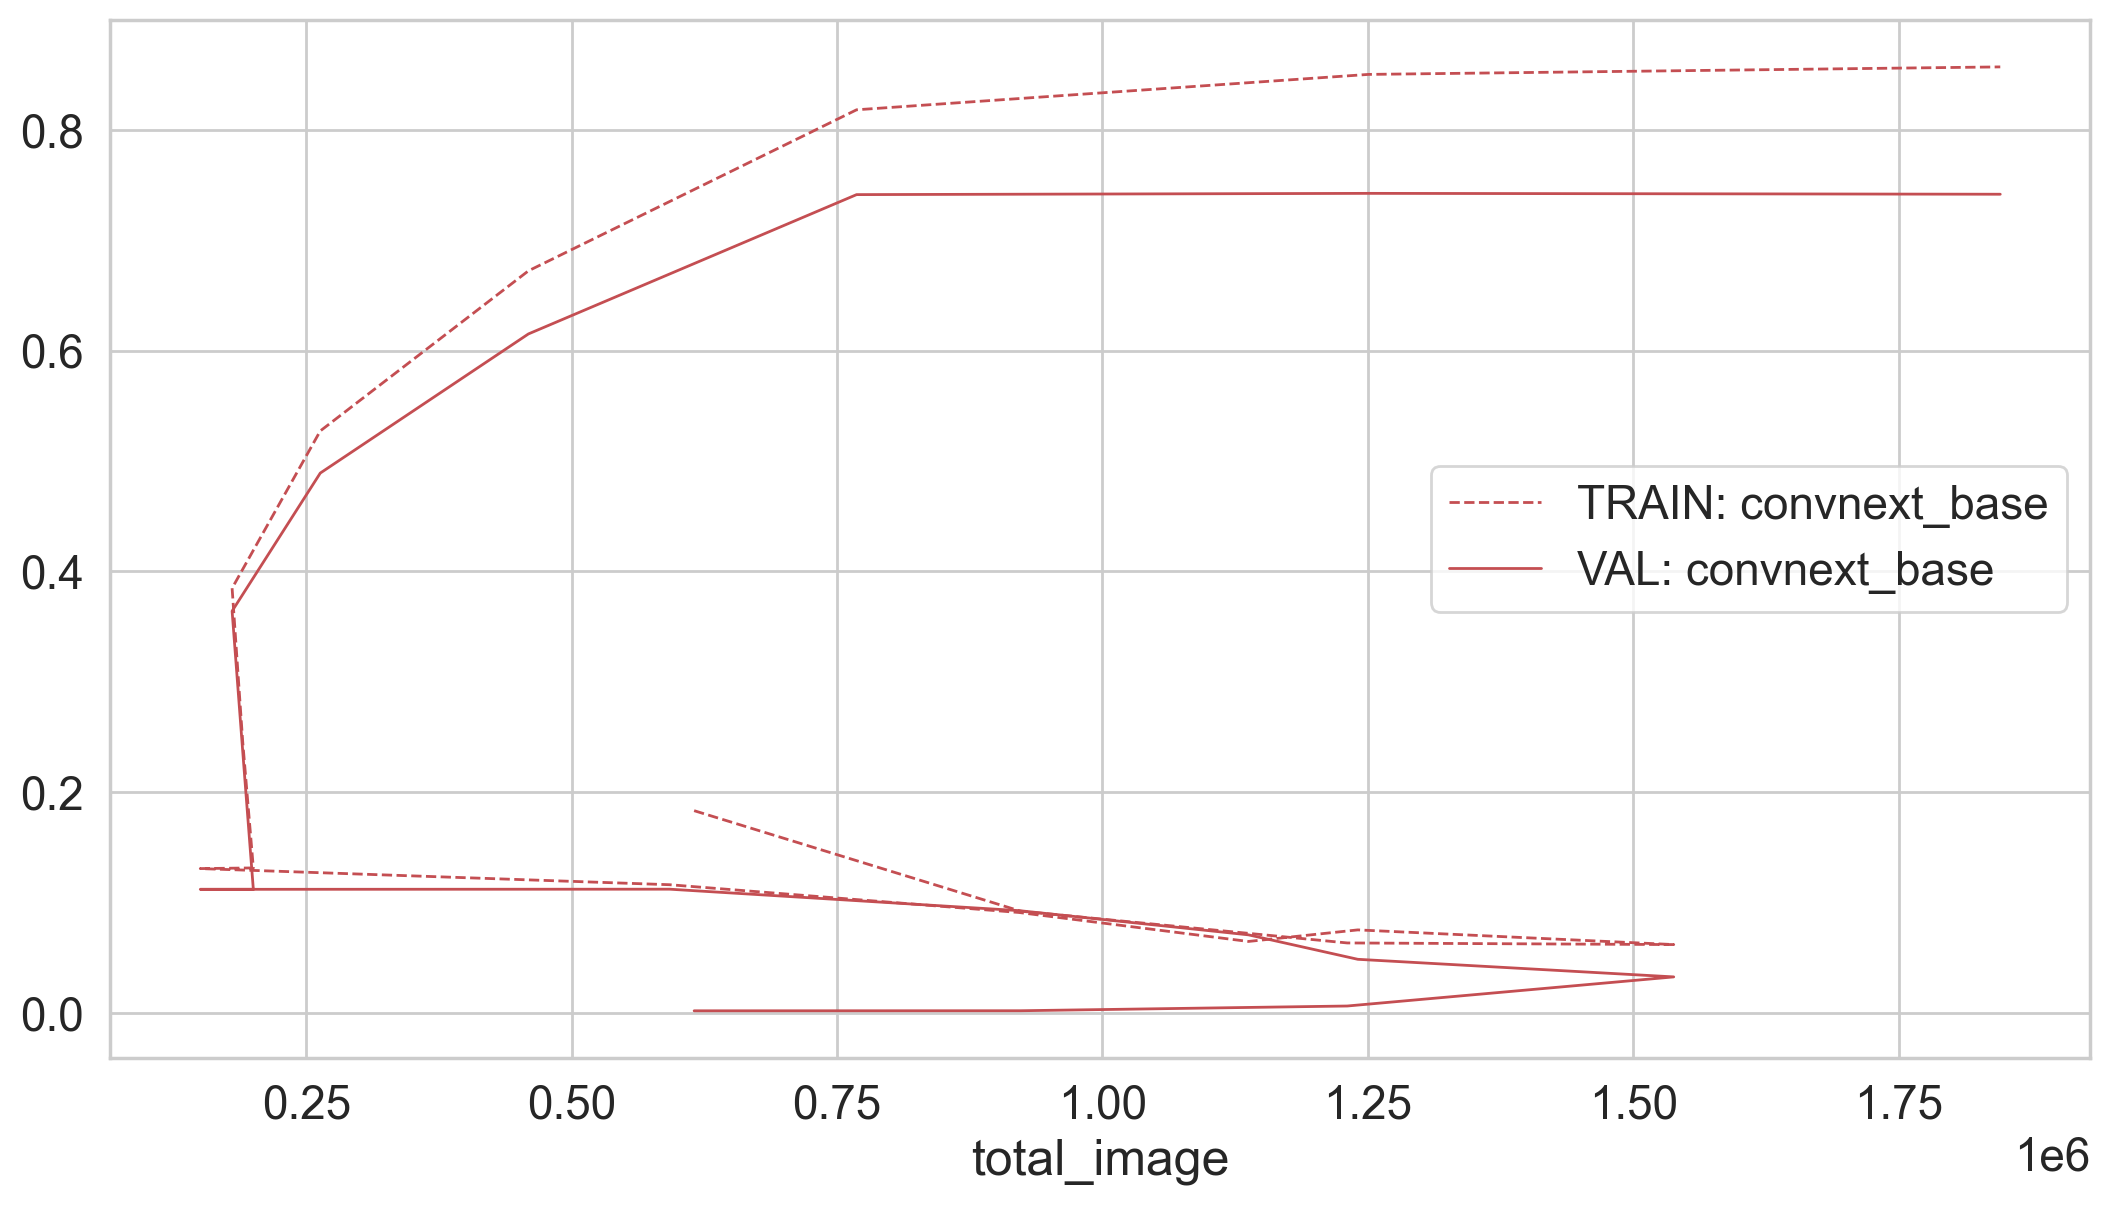

In [8]:
fig, ax = fovea.plt.subplots()
for dataset in ['bbox']: # fovea.params.all_datasets:
    color = 'r'
    lw = 1

    name = f'20_model_name={model_name}_dataset={dataset}'
    model_filename, json_filename = fovea.do_learning(args, dataset, name)

    df_train = fovea.pd.read_json(json_filename, orient='records')

    df_train_roll = df_train.rolling(window=5, min_periods=1, center=False).mean()
    ax = df_train_roll.plot(x='total_image', y='acc_train', 
                        c=color, ls='dashed', lw=lw,
                        grid=True, ax=ax, label='TRAIN: ' + args.model_name)    
    ax = df_train_roll.plot(x='total_image', y='acc_val', 
                        c=color, lw=lw,
                        grid=True, ax=ax, label='VAL: ' + args.model_name)   

In [9]:
df_train

,epoch,i_image,total_image,loss_train,acc_train,acc_val,time
0,0,615280,615280,0.367325,0.183375,0.002127,7061.567748
1,1,615280,1230560,0.150311,0.001325,0.002251,14210.541431
2,2,615280,1845840,0.072473,0.006046,0.015025,21278.239955
3,3,615280,2461120,0.034280,0.057676,0.111940,30808.037847
4,4,50000,50000,0.022540,0.128580,0.112500,332.306991
5,5,50000,100000,0.021312,0.131040,0.112900,565.880219
6,6,50000,150000,0.020166,0.132460,0.111900,790.243177
7,7,50000,200000,0.019102,0.131820,0.112100,1014.586353
8,8,50000,250000,0.018111,0.130700,0.111300,1239.127110
9,9,50000,300000,0.017187,0.131580,0.112600,1463.918579
